In [1]:
import numpy as np
import math
from math import pi
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.special import iv
#from scipy.linalg import expm, block_diag
from scipy import integrate
from openfermion import fermi_hubbard, jordan_wigner, get_sparse_operator
from collections import Counter

from qiskit import QuantumCircuit, QuantumRegister
from qiskit import Aer, transpile
#from qiskit.circuit import Parameter
#from qiskit.providers.fake_provider import FakeGuadalupe, FakeNairobi
#from qiskit.visualization import plot_histogram

from HA_utils import Assembly_ACDF, get_real_CDF, get_fh_matrix


In [2]:
def fh_evolution_trotter(N_sites, t, U, tau, j, step, to_gate=True):
    
    qr = QuantumRegister(2*N_sites,'qr')
    qc = QuantumCircuit(qr)
    
    for _ in range(step):
        
        ## Hopping terms 
        theta = tau*t*j/step
        
        for i in range(N_sites//2):
            qc.rxx(theta,2*i,2*i+1)
            qc.ryy(theta,2*i,2*i+1)

            qc.rxx(theta,2*i+N_sites,2*i+1+N_sites)
            qc.ryy(theta,2*i+N_sites,2*i+1+N_sites)
            
        for i in range((N_sites-1)//2):
            qc.rxx(theta,2*i+1,2*i+2)
            qc.ryy(theta,2*i+1,2*i+2)

            qc.rxx(theta,2*i+N_sites+1,2*i+2+N_sites)
            qc.ryy(theta,2*i+N_sites+1,2*i+2+N_sites)
        
        ## Potential
        gamma = tau*j*U/(2*step)
        
        for i in range(N_sites):
            qc.rzz(gamma,i,i+N_sites)
    return qc.to_gate() if to_gate else qc

def initial_state_prep(N_sites, initial_state_symmetry=True, to_gate=True):

    qr = QuantumRegister(2*N_sites,'q')
    qc = QuantumCircuit(qr)

    if initial_state_symmetry:
        qc.h(0)
        for i in range(N_sites):
            if i%2!=0:
                qc.x(i)
            else:
                qc.x(i+N_sites)

        qc.cnot(0,range(1,2*N_sites))

    else:
        for i in range(N_sites):
            if i%2!=0:
                qc.x(i)
            else:
                qc.x(i+N_sites)
        

    return qc.to_gate() if to_gate else qc

In [3]:
def get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, initial_state_symmetry=True,test_type='real'):

    qr = QuantumRegister(2*N_sites+2,'q')
    qc = QuantumCircuit(qr)

    qc.h([0,1])
    if test_type=='real':
        pass
    elif test_type=='imag':
        qc.s(0)

    
    prep_gate = initial_state_prep(N_sites=N_sites,initial_state_symmetry=initial_state_symmetry)
    qc.append(prep_gate.control(), [0]+list(range(2,2*N_sites+2)))

    evolution_gate = fh_evolution_trotter(N_sites=N_sites, t=t, U=U, tau=tau, j=j, step=step)
    qc.append(evolution_gate,range(2,2*N_sites+2))

    prep_gate_conj = prep_gate.reverse_ops()
    qc.append(prep_gate_conj.control(), [1]+list(range(2,2*N_sites+2)))

    qc.h([0,1])

    qc.measure_all()

    return qc

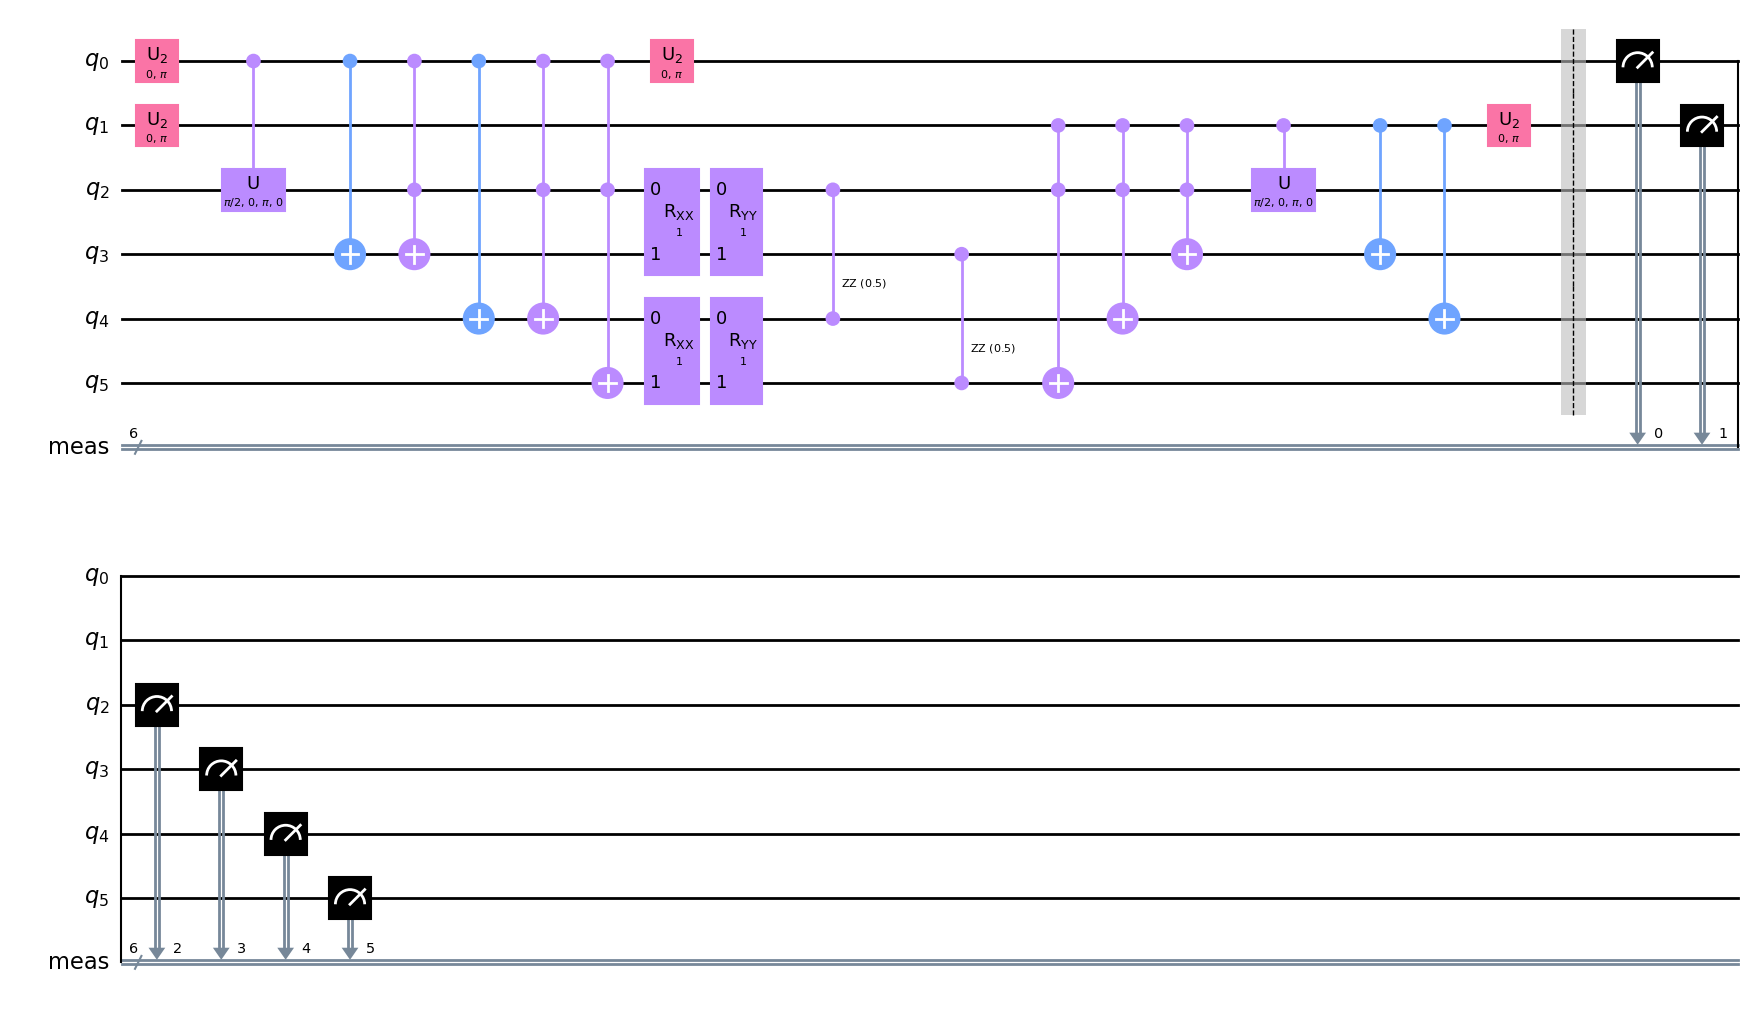

In [22]:
get_new_Hadamard_circuit(2,1,1,1,1,1).decompose().draw('mpl')

In [4]:
def get_new_Z(N_sites, t, U, tau, j, step, shots, initial_state_symmetry=True):

    qc_real = get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, initial_state_symmetry=initial_state_symmetry, test_type='real')
    qc_imag = get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, initial_state_symmetry=initial_state_symmetry, test_type='imag')
    backend=Aer.get_backend('qasm_simulator')

    qc_real = transpile(qc_real,backend)
    qc_imag = transpile(qc_imag,backend)
    job_real = backend.run(qc_real,shots=shots)
    job_imag = backend.run(qc_imag,shots=shots)
    
    counts_real = job_real.result().get_counts()
    counts_imag = job_imag.result().get_counts()

    p00, p01, p10, p11 = 0,0,0,0
    if ('0'*2*N_sites+'00') in counts_real.keys():
        p00 = counts_real['0'*2*N_sites+'00']/shots
    if ('0'*2*N_sites+'01') in counts_real.keys():
        p01 = counts_real['0'*2*N_sites+'01']/shots
    if ('0'*2*N_sites+'10') in counts_real.keys():
        p10 = counts_real['0'*2*N_sites+'10']/shots
    if ('0'*2*N_sites+'11') in counts_real.keys():
        p11 = counts_real['0'*2*N_sites+'11']/shots

    X = p00+p11-p01-p10

    p00, p01, p10, p11 = 0,0,0,0
    if ('0'*2*N_sites+'00') in counts_imag.keys():
        p00 = counts_imag['0'*2*N_sites+'00']/shots
    if ('0'*2*N_sites+'01') in counts_imag.keys():
        p01 = counts_imag['0'*2*N_sites+'01']/shots
    if ('0'*2*N_sites+'10') in counts_imag.keys():
        p10 = counts_imag['0'*2*N_sites+'10']/shots
    if ('0'*2*N_sites+'11') in counts_imag.keys():
        p11 = counts_imag['0'*2*N_sites+'11']/shots

    Y = p00+p11-p01-p10

    lambda_R = U/4*N_sites

    Z = 2*(X-1j*Y)*np.exp(-1j*lambda_R*j*tau)
    return Z

def get_shots_per_run(F_list, total_shots,type='sample'):

    F_list_abs = np.array([np.abs(ele) for ele in F_list])
    probs = F_list_abs/sum(F_list_abs)
    if type=='sample':
        sampling = np.random.choice(range(len(probs)), size=int(total_shots), p=probs)
        counter = Counter(sampling)

        shots_list = np.zeros(len(probs),dtype=int)
        for i in range(len(probs)):
            shots_list[i] = int(counter[i])
    elif type=='distribution':
        shots_list = np.round(total_shots*probs)
    return shots_list

def get_Z_list(d, N_sites, t, U, tau, step, shots_list, initial_state_symmetry=True): ## shots_per_run should be replaced
    
    #Z_list = [get_new_Z(N_sites, t, U, tau, 2*j+1, step, shots=shots_list) for j in range(d+1)]

    Z_list = np.zeros(d+1,dtype='complex')
    for j in range(d+1):
        if shots_list[j]:
            Z_list[j] = get_new_Z(N_sites, t, U, tau, 2*j+1, step, shots=shots_list[j],initial_state_symmetry=initial_state_symmetry)
    return Z_list

## Number of shots

In [40]:
N_sites = 2
t = 1
U = 4
d = 20000
step = 4
total_shots=5000
precision = 20000
initial_state_symmetry=True
F_list_import = np.load('F_list/F_list_d2e4_lim1e4.npy')


fh_matrix = get_fh_matrix(N_sites=N_sites, t=t, U=U)
tau = pi/(4*np.linalg.norm(fh_matrix,1))

shots_list = get_shots_per_run(F_list=F_list_import,
                               total_shots=total_shots)

Z_list = get_Z_list(d=d, N_sites=N_sites, t=t, U=U,
                    tau=tau, step=step, shots_list=shots_list,
                    initial_state_symmetry=initial_state_symmetry)

ACDF = Assembly_ACDF(Z_list=Z_list, F_list=F_list_import, precision=d)




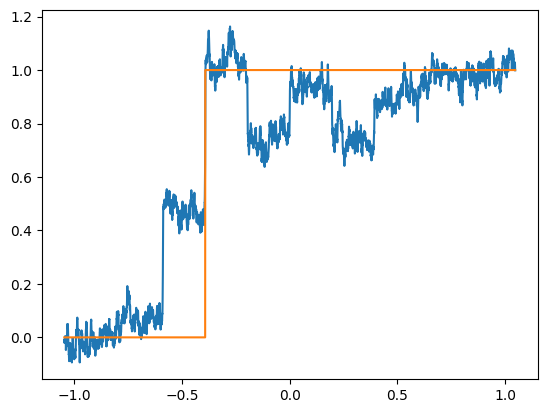

In [41]:
x_list=np.linspace(-pi/3,pi/3,precision)
plt.plot(x_list, ACDF)
plt.plot(x_list, get_real_CDF(N_sites=N_sites,t=t,U=U,tau=tau,initial_state_symmetry=initial_state_symmetry,precision=precision))

In [25]:
hubbard = fermi_hubbard(1, N_sites, t, U, periodic=False,particle_hole_symmetry=True)
jw_hamiltonian = jordan_wigner(hubbard)
fh_matrix = get_sparse_operator(jw_hamiltonian)
fh_matrix = fh_matrix.todense()
fh_matrix = fh_matrix.real

In [30]:
value, state = np.linalg.eig(fh_matrix)

In [34]:
state[:,0]

matrix([[ 0.00000000e+00],
        [-1.12730063e-17],
        [-3.36294514e-32],
        [ 2.70598050e-01],
        [-1.13438804e-17],
        [ 0.00000000e+00],
        [-6.53281482e-01],
        [ 0.00000000e+00],
        [ 6.23013085e-33],
        [ 6.53281482e-01],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 2.70598050e-01],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00]])